In [12]:
import sys
from datetime import datetime
from pathlib import Path

import numpy as np
import torch
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

from joblib import Parallel, delayed

sys.path.append(str(Path("..").resolve()))
from data_handling import load_measurements_npz, load_state_npz, MeasurementDataset, MeasurementLoader
from hyper_rbm import SymmetricHyperRBM, train_loop, get_sigmoid_curve, save_model
from wavefunction_overlap import generate_basis_states, calculate_exact_overlap, load_gt_wavefunction


data_dir = Path("measurements")
state_dir = Path("state_vectors")
models_dir = Path("models")
models_dir.mkdir(parents=True, exist_ok=True)

device = "cpu"
print(f"Running on: {device}")

Running on: cpu


In [2]:
SYSTEM_SIZE = 16
FILE_SAMPLE_COUNT = 20_000
TRAIN_SAMPLE_COUNT = 20_000

h_support = [0.50, 0.80, 0.95, 1.00, 1.05, 1.20, 1.50]
h_novel = [0.60, 0.70, 1.30, 1.40]
all_h_values = sorted(list(set(h_support + h_novel)))

file_names = [f"tfim_{SYSTEM_SIZE}_h{h:.2f}_{FILE_SAMPLE_COUNT}.npz" for h in h_support]
file_paths = [data_dir / fn for fn in file_names]

print(f"Support points: {h_support}")
print(f"Training on {TRAIN_SAMPLE_COUNT} samples per support point.")

samples_per_support = [TRAIN_SAMPLE_COUNT] * len(file_paths)
dataset = MeasurementDataset(file_paths, load_measurements_npz, ["h"], samples_per_support)

Support points: [0.5, 0.8, 0.95, 1.0, 1.05, 1.2, 1.5]
Training on 20000 samples per support point.


In [3]:
N_EPOCHS = 50
BATCH_SIZE = 1024
NUM_HIDDEN = 64
HYPER_NET_WIDTH = 64
K_STEPS = 20
GIBBS_NOISE_FRAC = 0.1
INIT_LR = 1e-2
FINAL_LR = 1e-4

# first try with 0.005 falloff then maybe less K_STEPS

def train_and_eval_seed(seed):
    seed = int(seed)
    print(f"Training seed {seed}...")

    torch.manual_seed(seed)
    rng = torch.Generator().manual_seed(seed)

    loader = MeasurementLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=False, rng=rng)

    model = SymmetricHyperRBM(num_v=SYSTEM_SIZE, num_h=NUM_HIDDEN, hyper_dim=HYPER_NET_WIDTH, k=K_STEPS).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=INIT_LR)
    scheduler = get_sigmoid_curve(INIT_LR, FINAL_LR, N_EPOCHS*len(loader), 0.005)

    model = train_loop(model, optimizer, loader, num_epochs=N_EPOCHS, lr_schedule_fn=scheduler, noise_frac=GIBBS_NOISE_FRAC, rng=rng)

    # Evaluation
    all_states = generate_basis_states(SYSTEM_SIZE, device)
    h_support_arr = np.asarray(h_support)

    overlap_rows = []
    for h_val in all_h_values:
        gt_path = state_dir / f"tfim_{SYSTEM_SIZE}_h{h_val:.2f}.npz"
        psi_true = load_gt_wavefunction(gt_path, device)

        overlap = calculate_exact_overlap(model, h_val, psi_true, all_states)
        split = "support" if np.isclose(h_support_arr, h_val, atol=1e-3).any() else "novel"

        overlap_rows.append({"h": float(h_val), "overlap": float(overlap), "split": split, "seed": seed})
        # print(f"Seed {seed} | h={h_val:.2f} ({split:7}) | Overlap = {overlap:.5f}")

    overlap_df = pd.DataFrame(overlap_rows)

    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    filename = f"hyprbm_tfim_16_{TRAIN_SAMPLE_COUNT}_seed{seed}_{timestamp}.pt"
    save_path = models_dir / filename

    config = { "train_samples": TRAIN_SAMPLE_COUNT, "epochs": N_EPOCHS, "h_support": h_support, "h_novel": h_novel, "seed": seed }
    save_model(model, config, overlap_rows, save_path)

    return overlap_df

In [4]:
all_seeds = np.arange(3) + 42

results_list = Parallel(n_jobs=4)(delayed(train_and_eval_seed)(seed) for seed in all_seeds)
all_overlaps = pd.concat(results_list, ignore_index=True)
print("Training and evaluation complete.")

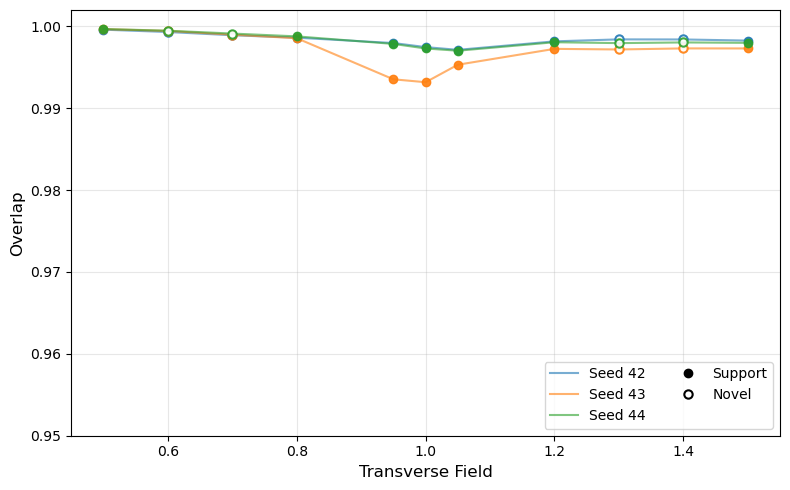

In [15]:
plt.figure(figsize=(8, 5), dpi=100)

unique_seeds = sorted(all_overlaps["seed"].unique())
cmap = plt.get_cmap("tab10")

for i, seed in enumerate(unique_seeds):
    df = all_overlaps[all_overlaps["seed"] == seed].sort_values("h")
    c = cmap(i % 10)

    # Plot line
    plt.plot(df["h"], df["overlap"], '-', color=c, alpha=0.6, label=f"Seed {seed}")

    # Plot Support markers (Solid)
    supp = df[df["split"] == "support"]
    plt.plot(supp["h"], supp["overlap"], 'o', color=c, markersize=6,
             alpha=0.9)

    # Plot Novel markers (White Filled, Colored Edge)
    nov = df[df["split"] == "novel"]
    plt.plot(nov["h"], nov["overlap"], 'o', color=c,
             markerfacecolor='white', markeredgewidth=1.5, markersize=6,
             alpha=0.9)

# Create custom legend handles to explain marker types
handles, labels = plt.gca().get_legend_handles_labels()

dummy_support = Line2D([0], [0], color='black', marker='o', linestyle='', label='Support')
dummy_novel   = Line2D([0], [0], color='black', marker='o', markerfacecolor='white', markeredgewidth=1.5, linestyle='', label='Novel')

handles.extend([dummy_support, dummy_novel])
labels.extend(["Support", "Novel"])

plt.xlabel(r"Transverse Field", fontsize=12)
plt.ylabel(r"Overlap", fontsize=12)
plt.ylim(0.95, 1.002)
plt.grid(True, alpha=0.3)
plt.legend(handles=handles, labels=labels, loc="lower right", ncol=2)
plt.tight_layout()
plt.show()

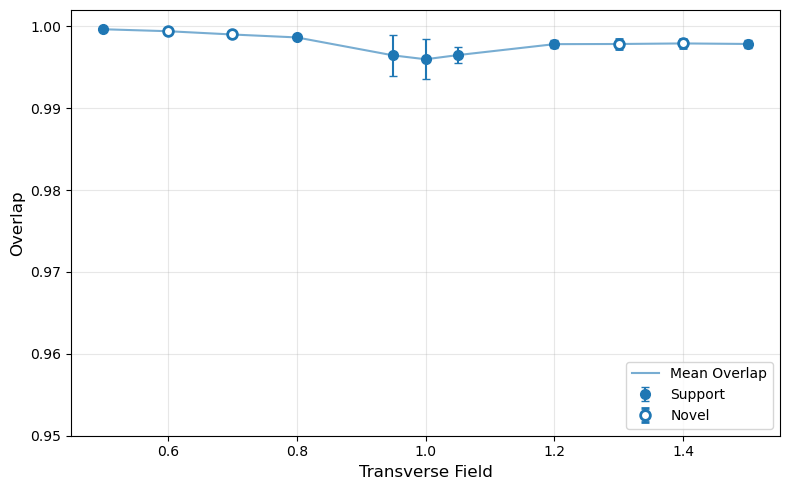

In [14]:
# Group by h and split to calculate stats
grouped = all_overlaps.groupby(["h", "split"])["overlap"]
mean_df = grouped.mean().reset_index().sort_values("h")
std_df = grouped.std().reset_index().sort_values("h")

support_mean = mean_df[mean_df["split"] == "support"]
novel_mean   = mean_df[mean_df["split"] == "novel"]
support_std  = std_df[std_df["split"] == "support"]
novel_std    = std_df[std_df["split"] == "novel"]

plt.figure(figsize=(8, 5), dpi=100)

# Plot Mean Line
plt.plot(mean_df["h"], mean_df["overlap"], '-', color='tab:blue', alpha=0.6, label="Mean Overlap")

# Plot Support with Error Bars
plt.errorbar(support_mean["h"], support_mean["overlap"], yerr=support_std["overlap"],
             fmt='o', color='tab:blue', markersize=7, label="Support", capsize=3)

# Plot Novel with Error Bars (White face style)
plt.errorbar(novel_mean["h"], novel_mean["overlap"], yerr=novel_std["overlap"],
             fmt='o', color='tab:blue', markerfacecolor='white', markeredgewidth=2,
             markersize=7, label="Novel", capsize=3)

plt.xlabel(r"Transverse Field", fontsize=12)
plt.ylabel(r"Overlap", fontsize=12)
plt.ylim(0.95, 1.002)
plt.grid(True, alpha=0.3)
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()